<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/vae_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder with Classifier
Adapted from fchollet: https://keras.io/examples/generative/vae/

Created 5/31/2021

Adds a separate classification head to a VAE to allow latent representation to be classified.

## Setup

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
latent_dim = 2
input_shape = (28, 28, 1)
epochs = 25
batch_size = 128
num_classes = 10
learning_rate = 5e-4

## Create a sampling layer

In [18]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [19]:
def encoder(input_shape):
    
    inputs = keras.Input(shape=input_shape, name='input_layer')
    # # Block 1
    # x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    # x = layers.BatchNormalization(name='bn_1')(x)
    # x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # # Block 2
    # x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    # x = layers.BatchNormalization(name='bn_2')(x)
    # x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # # Block 3
    # x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    # x = layers.BatchNormalization(name='bn_3')(x)
    # x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # # Block 4
    # x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    # x = layers.BatchNormalization(name='bn_4')(x)
    # x = layers.LeakyReLU(name='lrelu_4')(x)

    # # Final Block
    # x = layers.Flatten()(x)

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)


    # bottleneck = layers.Dense(latent_dim, name='latent_out')(flatten)
    # model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    z = Sampling()([z_mean, z_log_var])

    # instantiate encoder model
    model = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

    return model

## Build the decoder

In [20]:
def decoder():
    # Initial Block
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    
    # x = layers.Dense(7 * 7 * 64, name='dense_1')(inputs)
    # x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)

    # # Block 1
    # x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    # x = layers.BatchNormalization(name='bn_1')(x)
    # x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # # Block 2
    # x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    # x = layers.BatchNormalization(name='bn_2')(x)
    # x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # # Block 3
    # x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    # x = layers.BatchNormalization(name='bn_3')(x)
    # x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # # Block 4
    # outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='recon_out')(x)


    x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

## Define the classifier

In [21]:
def classifier():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    # x = layers.Dense(100, name='dense_1', activation='relu')(inputs)
    # x = layers.Dense(100, name='dense_2', activation='relu')(x)
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(inputs)
    model = tf.keras.Model(inputs, outp, name="classifier")

    return model

## Define the VAE as a `Model` with a custom `train_step`

In [22]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, classifier, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

        self.loss_weights = [0.006, 0.2, 20*0.5]

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.classifier_loss_tracker = keras.metrics.Mean(name="classifier_loss")
        self.classifier_acc_tracker = keras.metrics.Mean(name="classifier_acc")
        self.classifier_acc = tf.keras.metrics.CategoricalAccuracy()

        self.total_loss_val_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_val_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_val_tracker = keras.metrics.Mean(name="kl_loss")
        self.classifier_loss_val_tracker = keras.metrics.Mean(name="classifier_loss_val")
        self.classifier_acc_val_tracker = keras.metrics.Mean(name="classifier_acc_val")
        self.classifier_acc_val = tf.keras.metrics.CategoricalAccuracy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.classifier_loss_tracker,
            self.classifier_acc_tracker,

            self.total_loss_val_tracker,
            self.reconstruction_loss_val_tracker,
            self.kl_loss_val_tracker,
            self.classifier_loss_val_tracker,
            self.classifier_acc_val_tracker,
        ]

    def train_step(self, data):
        # Unpack input
        X, y = data

        with tf.GradientTape() as tape:
            # Encode the input image
            z_mean, z_log_var, z = self.encoder(X)

            # Decode the latent code to reconstruct the image
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(X, reconstruction), axis=(1, 2)
                )
            )
            reconstruction_loss *= self.loss_weights[0]

            # Encourage the latent code to be normally distributed
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= self.loss_weights[1]

            # Classify the latent code
            yhat = self.classifier(z)
            # print('**yhat:', yhat.shape)
            classifier_loss = tf.reduce_mean(
                    keras.losses.categorical_crossentropy(y, yhat)
            )
            classifier_loss *= self.loss_weights[2]

            self.classifier_acc.update_state(y, yhat)
            classifier_acc = self.classifier_acc.result()
            
            total_loss = reconstruction_loss + kl_loss + classifier_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.classifier_loss_tracker.update_state(classifier_loss)
        self.classifier_acc_tracker.update_state(classifier_acc)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "classifier_loss": self.classifier_loss_tracker.result(),
            "classifier_acc": self.classifier_acc_tracker.result(),
        }

    def test_step(self, data):
        self.classifier_acc_val.reset_state()

        # Unpack the data
        X, y = data
        # Encode the input image
        z_mean, z_log_var, z = self.encoder(X)
        # Decode the latent code to reconstruct the image
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(X, reconstruction), axis=(1, 2)
            )
        )
        reconstruction_loss *= self.loss_weights[0]

        # Encourage the latent code to be normally distributed
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        kl_loss *= self.loss_weights[1]

        # Classify the latent code
        yhat = self.classifier(z)
        classifier_loss = tf.reduce_mean(
                keras.losses.categorical_crossentropy(y, yhat)
        )
        classifier_loss *= self.loss_weights[2]
        
        total_loss = reconstruction_loss + kl_loss + classifier_loss

        self.classifier_acc_val.update_state(y, yhat)
        classifier_acc = self.classifier_acc_val.result()

        self.total_loss_val_tracker.update_state(total_loss)
        self.reconstruction_loss_val_tracker.update_state(reconstruction_loss)
        self.kl_loss_val_tracker.update_state(kl_loss)
        self.classifier_loss_val_tracker.update_state(classifier_loss)
        self.classifier_acc_val_tracker.update_state(classifier_acc)
        return {
            "loss": self.total_loss_val_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_val_tracker.result(),
            "kl_loss": self.kl_loss_val_tracker.result(),
            "classifier_loss": self.classifier_loss_val_tracker.result(),
            "classifier_acc": self.classifier_acc_val_tracker.result(),
        }

## Data

In [23]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000, 10)


## Train the VAE

In [24]:
enc = encoder(input_shape)
dec = decoder()
clf = classifier()
vae = VAE(enc, dec, clf)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
hist = vae.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.1)
# hist = vae.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)

Epoch 1/25
422/422 [==============================] - 7s 13ms/step - loss: 21.0704 - reconstruction_loss: 1.3902 - kl_loss: 1.4544 - classifier_loss: 15.3769 - classifier_acc: 0.3101 - val_loss: 15.0628 - val_reconstruction_loss: 1.1230 - val_kl_loss: 2.0705 - val_classifier_loss: 11.8693 - val_classifier_acc: 0.5703
Epoch 2/25
422/422 [==============================] - 5s 12ms/step - loss: 14.5910 - reconstruction_loss: 1.1022 - kl_loss: 2.2024 - classifier_loss: 10.7973 - classifier_acc: 0.4744 - val_loss: 13.0055 - val_reconstruction_loss: 1.0717 - val_kl_loss: 2.3979 - val_classifier_loss: 9.5359 - val_classifier_acc: 0.7451
Epoch 3/25
422/422 [==============================] - 5s 12ms/step - loss: 12.9160 - reconstruction_loss: 1.0730 - kl_loss: 2.3620 - classifier_loss: 9.2044 - classifier_acc: 0.5722 - val_loss: 11.9549 - val_reconstruction_loss: 1.0531 - val_kl_loss: 2.4389 - val_classifier_loss: 8.4629 - val_classifier_acc: 0.8121
Epoch 4/25
422/422 [==========================

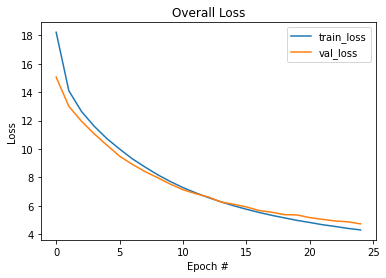

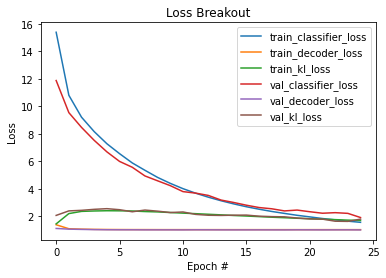

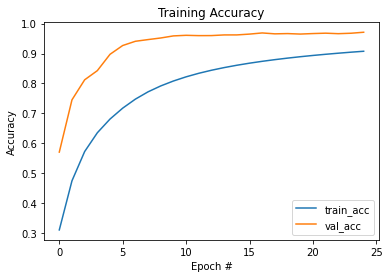

In [25]:
# construct a plot that plots and saves the training history
# plt.style.use("ggplot")
plt.figure()
plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
plt.title("Overall Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('total_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_loss"], label="train_classifier_loss")
plt.plot(hist.epoch, hist.history["reconstruction_loss"], label="train_decoder_loss")
plt.plot(hist.epoch, hist.history["kl_loss"], label="train_kl_loss")
plt.plot(hist.epoch, hist.history["val_classifier_loss"], label="val_classifier_loss")
plt.plot(hist.epoch, hist.history["val_reconstruction_loss"], label="val_decoder_loss")
plt.plot(hist.epoch, hist.history["val_kl_loss"], label="val_kl_loss")
plt.title("Loss Breakout")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('indiv_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_acc"], label="train_acc")
plt.plot(hist.epoch, hist.history["val_classifier_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('classifier_acc.png')
plt.show()

0.9686
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.91      0.97      0.94      1032
           3       0.98      0.96      0.97      1010
           4       0.99      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.95      0.98      0.96       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



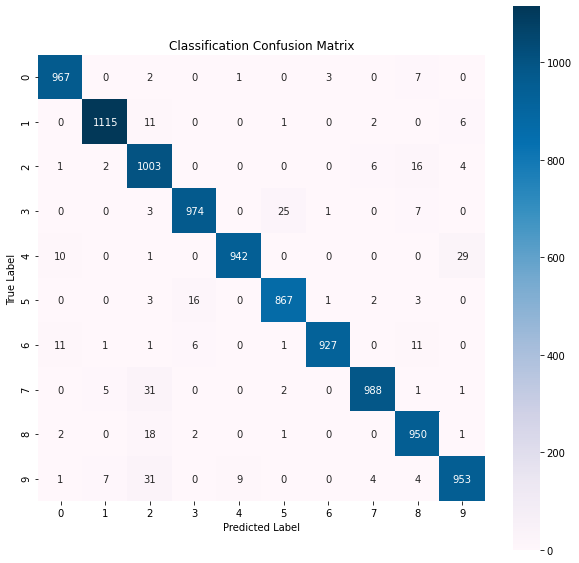

In [26]:
# Check accuracy

# Encode the input image
z_mean, z_log_var, z = enc(x_test)

# Classify the latent code
y_pred = clf(z)

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test_one_hot, y_pred)
print(m.result().numpy())

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


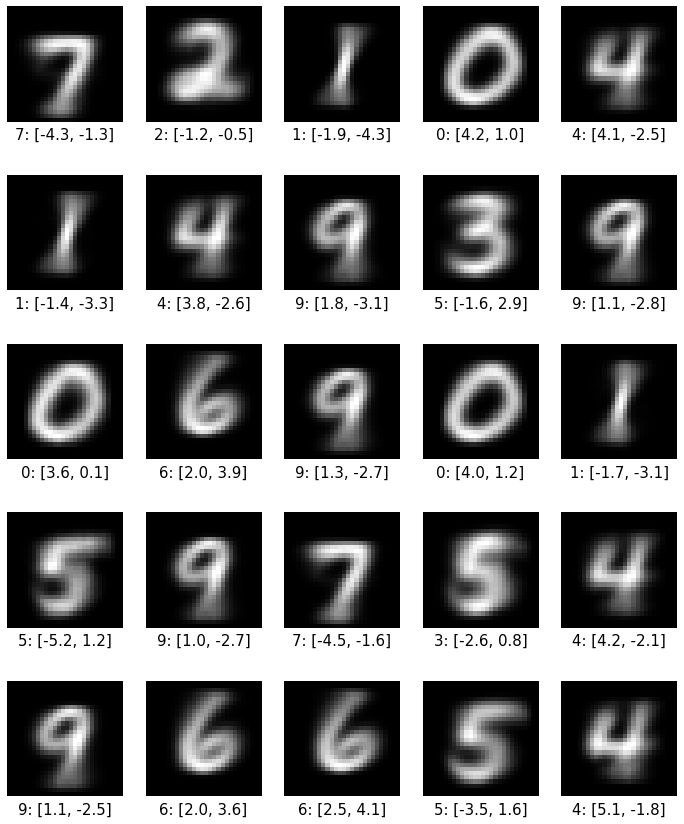

In [27]:
figsize = 12

m, s, latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 15))
#fig.subplots_adjust(wspace=-0.021)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    plt.text(0.5, -0.15, '{}: [{:.1f}, {:.1f}]'.format(y_test[i], latent[i, 0], latent[i, 1]), fontsize=15, ha='center', transform=ax.transAxes)
    #plt.subplots_adjust(wspace=None, hspace=None)
    plt.imshow(reconst[i, :,:,0]*255, cmap = 'gray')
plt.show()

## Display how the latent space clusters different digit classes

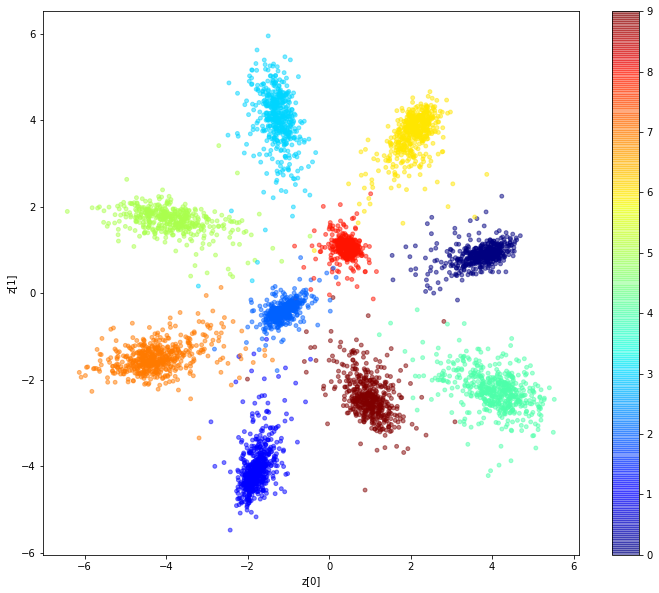

In [28]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], 15, c=labels, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train[:5000], y_train[:5000])

## Display a grid of sampled digits

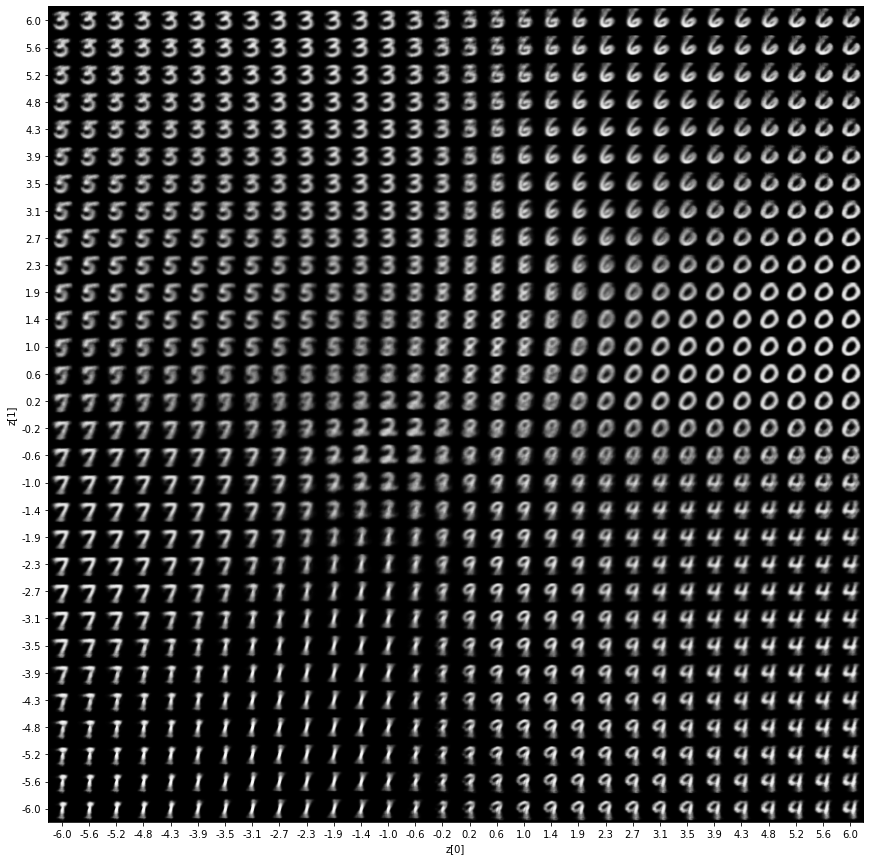

In [30]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 6.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)